In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import display
from IPython.display import display_html 
import sys
import os
import jax
import numpyro
numpyro.set_platform('cpu')
print(jax.lib.xla_bridge.get_backend().platform)
import jax.numpy as jnp

cpu


/home/user/.virtualenvs/graph-network/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# paths
_ROOT_DIR = "/home/user/graphical-models-external-networks/"
os.chdir(_ROOT_DIR)
sys.path.append("/home/user/graphical-models-external-networks/Network_Spike_and_Slab/numpyro/functions")

data_path = './Data/COVID/Pre-processed Data/'
data_save_path = '/home/user/mounted_folder/NetworkSS_results/'
if not os.path.exists(data_save_path):
    os.makedirs(data_save_path, mode=0o777)

# load models and functions
import models
import my_utils

Is 64 precision enabled?: True
Is 64 precision enabled?: True


In [4]:
covid_vals = jnp.array(pd.read_csv(data_path + 'COVID_629_meta.csv', index_col='Unnamed: 0').values)
geo_clean = jnp.array(jnp.load(data_path + 'GEO_clean_629.npy'))
sci_clean = jnp.array(jnp.load(data_path + 'SCI_clean_629.npy'))
net_no = 2
scale_spike_fixed =0.003

n,p = covid_vals.shape

# Compile results

In [5]:
# 1MCMC
output_dict_ss_geo_sci = {"eta0_0":[],"eta0_coefs":[], "eta1_0":[],"eta1_coefs":[], "eta2_0":[],"eta2_coefs":[],
                    "w_slab":[], "mean_slab":[], "scale_slab":[],"Pos":[], "Neg":[], "Pos_95":[], "Neg_95":[],}


outputs = {"NetworkSS_geo_sci":output_dict_ss_geo_sci }
        
# with open(data_save_path + f'NetworkSS_geo_sci_1mcmc.sav', 'rb') as fr:
#     res_ss_geo_sci = pickle.load(fr)

with open(data_save_path + f'NetworkSS_1mcmc_p629_s1500.sav', 'rb') as fr:
    res_ss_geo_sci = pickle.load(fr)

all_res = {"NetworkSS_geo_sci":res_ss_geo_sci}

for i, res in all_res.items():
    print(i)
    n_samples = res["eta1_0"].shape[0]


    outputs[i]["eta1_0"].append(res["eta1_0"].mean(0))

    try:
        outputs[i]["eta0_0"].append(res["eta0_0"].mean(0))
        outputs[i]["eta2_0"].append(res["eta2_0"].mean(0))
        outputs[i]["w_slab"].append(res["w_slab"].mean(0))
        outputs[i]["mean_slab"].append(res["mean_slab"].mean(0))
        outputs[i]["scale_slab"].append(res["scale_slab"].mean(0))

    except:
        pass

    try:
        outputs[i]["eta1_coefs"].append(res["eta1_coefs"].mean(0))
    except:
        pass

    try:   
        outputs[i]["eta0_coefs"].append(res["eta0_coefs"].mean(0))
        outputs[i]["eta2_coefs"].append(res["eta2_coefs"].mean(0))
    except:
        pass

    prob_slab_all = []
    for cs in range(n_samples):
        prob_slab = my_utils.get_prob_slab(rho_lt=res['rho_lt'][cs], 
                                        mean_slab=res['mean_slab'][cs], 
                                        scale_slab=res['scale_slab'][cs], 
                                        scale_spike=scale_spike_fixed, 
                                        w_slab=res['w_slab'][cs], 
                                        w_spike=(1-res['w_slab'])[cs])
        prob_slab_all.append(prob_slab)
    prob_slab_est = (jnp.array(prob_slab_all)).mean(0)    
    nonzero_preds_5 = (prob_slab_est>0.5).astype(int)
    nonzero_preds_95 = (prob_slab_est>0.95).astype(int)

    Pos_5 = jnp.where(nonzero_preds_5 == True)[0].shape[0]
    Neg_5 = jnp.where(nonzero_preds_5 == False)[0].shape[0]
  
    Pos_95 = jnp.where(nonzero_preds_95 == True)[0].shape[0]
    Neg_95 = jnp.where(nonzero_preds_95 == False)[0].shape[0]

    outputs[i]['Pos'].append(Pos_5)
    outputs[i]['Neg'].append(Neg_5)
    outputs[i]['Pos_95'].append(Pos_95)
    outputs[i]['Neg_95'].append(Neg_95)

outputs_1MCMC = outputs

NetworkSS_geo_sci


In [6]:
# 2MCMC

output_dict_ss_geo_sci = {"eta0_0":[],"eta0_coefs":[], "eta1_0":[],"eta1_coefs":[], "eta2_0":[],"eta2_coefs":[],
                    "w_slab":[], "mean_slab":[], "scale_slab":[],"Pos":[], "Neg":[], "Pos_95":[], "Neg_95":[],}


outputs = {"NetworkSS_geo_sci":output_dict_ss_geo_sci}

with open(data_save_path + f'NetworkSS_2mcmc_p629_s1500.sav', 'rb') as fr:
    mcmc2_ss_geo_sci = pickle.load(fr)


all_res_2MCMC = {"NetworkSS_geo_sci":mcmc2_ss_geo_sci}
for i, res in all_res_2MCMC.items():
    print(i)

    n_samples = res["rho_lt"].shape[0]

    prob_slab_all = []
    for cs in range(n_samples):
        prob_slab = my_utils.get_prob_slab(rho_lt=res['rho_lt'][cs], 
                                        mean_slab=res['mean_slab'][cs], 
                                        scale_slab=res['scale_slab'][cs], 
                                        scale_spike=scale_spike_fixed, 
                                        w_slab=res['w_slab'][cs], 
                                        w_spike=(1-res['w_slab'])[cs])
        prob_slab_all.append(prob_slab)
    prob_slab_est = (jnp.array(prob_slab_all)).mean(0)    
    nonzero_preds_5 = (prob_slab_est>0.5).astype(int)
    nonzero_preds_95 = (prob_slab_est>0.95).astype(int)

    Pos_5 = jnp.where(nonzero_preds_5 == True)[0].shape[0]
    Neg_5 = jnp.where(nonzero_preds_5 == False)[0].shape[0]
  
    Pos_95 = jnp.where(nonzero_preds_95 == True)[0].shape[0]
    Neg_95 = jnp.where(nonzero_preds_95 == False)[0].shape[0]

    outputs[i]['Pos'].append(Pos_5)
    outputs[i]['Neg'].append(Neg_5)
    outputs[i]['Pos_95'].append(Pos_95)
    outputs[i]['Neg_95'].append(Neg_95)


outputs_2MCMC = outputs

NetworkSS_geo_sci


# Summary

In [7]:
cols = ['Pos', 'Neg', 'Pos_95', 'Neg_95']

res_dict_1MCMC = {"NetworkSS_geo_sci":[]}
for k, output in outputs_1MCMC.items():
    for col in cols:
        try:
            res_dict_1MCMC[k].append(round(jnp.array(output[col]).mean(0),3))
        except:
            res_dict_1MCMC[k].append(np.nan)

In [8]:
cols = ['Pos', 'Neg', 'Pos_95', 'Neg_95']

res_dict_2MCMC = {"NetworkSS_geo_sci":[]}
for k, output in outputs_2MCMC.items():
    for col in cols:
        try:
            res_dict_2MCMC[k].append(round(jnp.array(output[col]).mean(0),3))
        except:
            res_dict_2MCMC[k].append(np.nan)

In [9]:
print('Results for 1MCMC')
pd.DataFrame.from_dict(res_dict_1MCMC, orient='index', 
                       columns=cols).loc[['NetworkSS_geo_sci']]

Results for 1MCMC


,Pos,Neg,Pos_95,Neg_95
NetworkSS_geo_sci,2654.0,194852.0,547.0,196959.0


In [10]:
print('Results for 2MCMC')
df = pd.DataFrame.from_dict(res_dict_2MCMC, orient='index', 
                       columns=cols).loc[['NetworkSS_geo_sci']]

df.index = ['GOLAZO_SS_geo_sci_2mcmc']
df

Results for 2MCMC


,Pos,Neg,Pos_95,Neg_95
GOLAZO_SS_geo_sci_2mcmc,3051.0,194455.0,578.0,196928.0


In [13]:
# NetworkSS_geo_sci 
cols = ["eta0_0", "eta1_0","eta2_0"]
cols_2 = [ "eta0_coefs", "eta1_coefs", "eta2_coefs"]
names = ['E', 'P']
etas_NetworkSS = {}
for k in cols:
    etas_NetworkSS[k] = all_res_2MCMC['NetworkSS_geo_sci']['fixed_params_dict'][k]
    
for k in cols:
    etas_NetworkSS[k] = {'MAP': all_res_2MCMC['NetworkSS_geo_sci']['fixed_params_dict'][k],
               'mean': all_res['NetworkSS_geo_sci'][k].mean(0),
              'ESS': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_geo_sci'][k],0))['Param:0']['n_eff'],
               'r_hat': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_geo_sci'][k],0))['Param:0']['r_hat'],
                }

for k in cols_2:
    for net_ix in range(net_no):
        etas_NetworkSS[f'{k}_{names[net_ix]}'] = {'MAP': all_res_2MCMC['NetworkSS_geo_sci']['fixed_params_dict'][k][net_ix],
                   'mean': all_res['NetworkSS_geo_sci'][k].mean(0)[net_ix],
                  'ESS': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_geo_sci'][k][:,net_ix].flatten(),0))['Param:0']['n_eff'],
                   'r_hat': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_geo_sci'][k][:,net_ix].flatten(),0))['Param:0']['r_hat'],
                    }
        
df_NetworkSS_etas_spec = pd.DataFrame.from_dict(etas_NetworkSS, orient='index')


In [14]:
df_NetworkSS_etas_spec

,MAP,mean,ESS,r_hat
eta0_0,0.015815815815815815,0.01592698153271592,4.654721,1.770011
eta1_0,-2.6056056056056054,-2.620358498320209,4.051418,1.690243
eta2_0,-3.193193193193193,-3.19633029947477,3.455242,1.892335
eta0_coefs_E,-0.0030030030030030186,-0.0031608785289137364,20.277500,1.020488
eta0_coefs_P,-0.01941941941941941,-0.02025489706879422,3.615602,1.638568
eta1_coefs_E,-0.048048048048048075,-0.04828101816736743,26.700894,1.003385
eta1_coefs_P,-0.06306306306306309,-0.06294306424340075,6.816175,1.319841
eta2_coefs_E,0.3733733733733735,0.37749870836791644,9.583342,1.139368
eta2_coefs_P,0.5135135135135136,0.5164734276812442,10.800271,0.998498


In [15]:
tril_idx = jnp.tril_indices(n=p, k=-1, m=p)
A_tril_geo = geo_clean[tril_idx]
A_tril_sci = sci_clean[tril_idx]

# NetworkSS

In [16]:
nbins=10

In [17]:
fixed_params_MAP_dict = all_res_2MCMC['NetworkSS_geo_sci']['fixed_params_dict']

In [18]:
negative_fixed_params_MAP_dict = {k:(-v if 'eta0' in k else v) 
                              for k,v in fixed_params_MAP_dict.items()
                             }

In [19]:
etas_dict = negative_fixed_params_MAP_dict

In [20]:
A_geo_ints_10, A_geo_mids_10  = my_utils.get_density_els_marginal(A_tril=A_tril_geo, 
                                                                  A_tril_pos=0, 
                                                                len_A_list=2, nbins=nbins, 
                         eta_dict=etas_dict)

In [21]:
A_sci_ints_10, A_sci_mids_10 = my_utils.get_density_els_marginal(A_tril=A_tril_sci, 
                                                                 A_tril_pos=1, 
                                                                len_A_list=2, nbins=nbins, 
                         eta_dict=etas_dict)

## Final plots

In [22]:
def get_credible_interval(post_chain):
    # Credible Intervals
    sorted_arr = np.sort(post_chain) # for each K sort chain
    len_sample = post_chain.shape[0] # len chain

    # 2.5% percentile: if integer pick value, else average of values at pos5 and pos5+1, recall python idx at 0 (lower bound)
    pos025 = 0.025*len_sample
    if pos025 == np.int(pos025):
        lb025 = sorted_arr[max(np.int(pos025)-1,0)]
    else:
        lb025 = (sorted_arr[max(np.int(pos025)-1,0)] + sorted_arr[np.int(pos025)])/2

    # 97.5% percentile: if integer pick value, else average of values at pos95 and pos95+1, recall python idx at 0 (upper bound)
    pos975 = 0.975*len_sample
    if pos975 == np.int(pos975):
        ub975 = sorted_arr[np.int(pos975)-1]
    else:
        ub975 = (sorted_arr[(np.int(pos975)-1)] + sorted_arr[np.int(pos975)])/2
        
    return (jnp.round(lb025,3), jnp.round(ub975,3))


In [24]:
df_MAP_dict = {'intercept':{'eta0_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta0_0'],3),
                        'eta0_CI':get_credible_interval(res_ss_geo_sci['eta0_0']),
                        'eta1_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta1_0'],3),
                        'eta1_CI':get_credible_interval(res_ss_geo_sci['eta1_0']),
                        'eta2_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta2_0'],3),
                        'eta2_CI':get_credible_interval(res_ss_geo_sci['eta2_0']),},
               
'geo':{'eta0_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta0_coefs_E'],3),
                        'eta0_CI':get_credible_interval(res_ss_geo_sci['eta0_coefs'][:,0]),
                        'eta1_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta1_coefs_E'],3),
                        'eta1_CI':get_credible_interval(res_ss_geo_sci['eta1_coefs'][:,0]),
                        'eta2_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta2_coefs_E'],3),
                        'eta2_CI':get_credible_interval(res_ss_geo_sci['eta2_coefs'][:,0]),},

'sci':{'eta0_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta0_coefs_P'],3),
                        'eta0_CI':get_credible_interval(res_ss_geo_sci['eta0_coefs'][:,1]),
                        'eta1_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta1_coefs_P'],3),
                        'eta1_CI':get_credible_interval(res_ss_geo_sci['eta1_coefs'][:,1]),
                        'eta2_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta2_coefs_P'],3),
                        'eta2_CI':get_credible_interval(res_ss_geo_sci['eta2_coefs'][:,1]),},
}

/home/user/.virtualenvs/graph-network/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/home/user/.virtualenvs/graph-network/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

In [25]:
pd.DataFrame.from_dict(df_MAP_dict)

,intercept,geo,sci
eta0_m,0.016,-0.003,-0.019
eta0_CI,"(0.012, 0.02)","(-0.006, -0.001)","(-0.027, -0.016)"
eta1_m,-2.606,-0.048,-0.063
eta1_CI,"(-2.786, -2.477)","(-0.092, -0.017)","(-0.1, -0.014)"
eta2_m,-3.193,0.373,0.514
eta2_CI,"(-3.5020000000000002, -2.89)","(0.303, 0.455)","(0.444, 0.604)"


In [26]:
pd.DataFrame.from_dict(df_MAP_dict).to_latex()

'\\begin{tabular}{llll}\n\\toprule\n{} &                     intercept &               geo &               sci \\\\\n\\midrule\neta0\\_m  &                         0.016 &            -0.003 &            -0.019 \\\\\neta0\\_CI &                 (0.012, 0.02) &  (-0.006, -0.001) &  (-0.027, -0.016) \\\\\neta1\\_m  &                        -2.606 &            -0.048 &            -0.063 \\\\\neta1\\_CI &              (-2.786, -2.477) &  (-0.092, -0.017) &    (-0.1, -0.014) \\\\\neta2\\_m  &                        -3.193 &             0.373 &             0.514 \\\\\neta2\\_CI &  (-3.5020000000000002, -2.89) &    (0.303, 0.455) &    (0.444, 0.604) \\\\\n\\bottomrule\n\\end{tabular}\n'

In [27]:
def MODIFIED_get_density_els_marginal(A_tril, A_min, A_max, A_tril_pos, len_A_list, nbins, eta_dict):
    bins = np.histogram(A_tril, bins=nbins)[1]
    delta = jnp.diff(np.histogram(A_tril, bins=nbins)[1])[0]
    if min(bins) > A_min:
        low = bins[0]
        while low>A_min:
            low -= delta
            bins = jnp.concatenate([jnp.array([low]), bins])
    if max(bins) < A_max:
        high = bins[-1]
        while high<A_max:
            high += delta
            bins = jnp.concatenate([bins, jnp.array([high])])

    A_ints = {}
    A_mids = []
    down = -jnp.inf
    for i in range(-1, len(bins)-2):
        up = bins[i+2]
        if i==-1:
            A_mid = up-(bins[i+3]-bins[i+2])/2
            A_mids.append(A_mid)
        else:
            A_mid = (down+up)/2
            A_mids.append(A_mid)
        A_int_ix = jnp.where((A_tril>down)&(A_tril<=up))[0]

        A_key = f'{jnp.round(down,2)} to {jnp.round(up,2)}'
        down = bins[i+2]

        zeros = jnp.zeros((len_A_list))
        A_singlevals = zeros.at[A_tril_pos].set(A_mid)

        par_dict = my_utils.from_etas_to_params(coef_dict=eta_dict, p=1, 
        model='golazo_ss', A_list=A_singlevals)

        A_ints[A_key] = par_dict

    A_mids = jnp.array(A_mids)
    return A_ints, A_mids

In [28]:
# run to have plots in LaTeX format

params = {'font.family': 'serif',
          'text.usetex': True,
          'axes.titlesize': 13,
          'axes.labelsize': 13,
          'xtick.labelsize': 13,
          'ytick.labelsize': 13,
          'legend.fontsize': 9,
          'font.weight': 'bold'}
plt.rcParams.update(params)

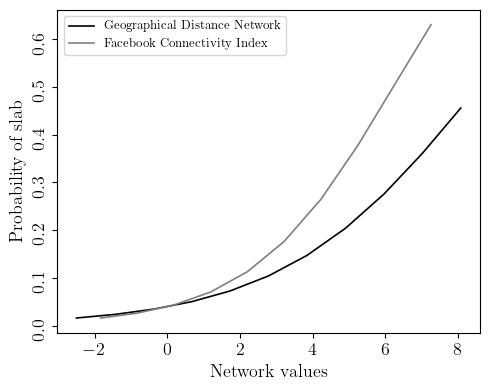

In [29]:
fig, ax = plt.subplots( figsize=(5,4))

nbins=10
MODIFIED_A_geo_ints_10, MODIFIED_A_geo_mids_10  = MODIFIED_get_density_els_marginal(A_tril=A_tril_geo, 
                                                                  A_min=-2, A_max=6.5, 
                                                                  A_tril_pos=0, 
                                                                len_A_list=2, nbins=nbins,  eta_dict=etas_dict)

MODIFIED_A_sci_ints_10, MODIFIED_A_sci_mids_10 = MODIFIED_get_density_els_marginal(A_tril=A_tril_sci, 
                                                                                   A_min=-2, A_max=6.5,
                                                                 A_tril_pos=1, 
                                                                len_A_list=2, nbins=nbins, eta_dict=etas_dict)


MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_sci_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_sci = MODIFIED_df.round(decimals = 5)

MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_geo_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_geo = MODIFIED_df.round(decimals = 5)

dfs = [MODIFIED_df_geo, MODIFIED_df_sci, ]
df_names = ['geo', 'sci', ]
ticklabs = [MODIFIED_A_geo_mids_10, MODIFIED_A_sci_mids_10 ]
legendlabs = ['Geographical Distance Network', 'Facebook Connectivity Index', ]
colors = ['black', 'gray']


for df_ix, df in enumerate(dfs):
    ax.plot(ticklabs[df_ix], df['w_slab'].values, linewidth=1.2, label=legendlabs[df_ix], color=colors[df_ix])

    ax.set_ylabel('Probability of slab')
    ax.set_xlabel('Network values')

plt.legend()
plt.yticks(rotation = 90)
plt.tight_layout()
plt.savefig('Stock_SS_prob_slab.pdf')

plt.show()

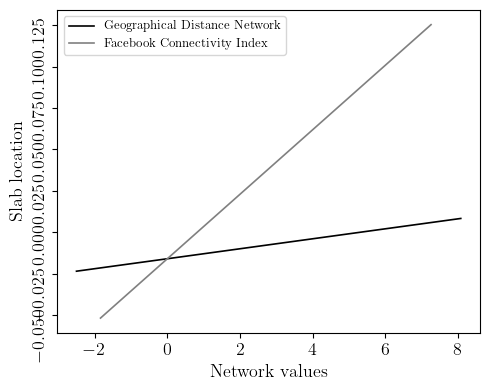

In [36]:
fig, ax = plt.subplots( figsize=(5,4))

nbins=10
MODIFIED_A_geo_ints_10, MODIFIED_A_geo_mids_10  = MODIFIED_get_density_els_marginal(A_tril=A_tril_geo, 
                                                                  A_min=-2, A_max=6.5, 
                                                                  A_tril_pos=0, 
                                                                len_A_list=2, nbins=nbins,  eta_dict=etas_dict)

MODIFIED_A_sci_ints_10, MODIFIED_A_sci_mids_10 = MODIFIED_get_density_els_marginal(A_tril=A_tril_sci, 
                                                                                   A_min=-2, A_max=6.5,
                                                                 A_tril_pos=1, 
                                                                len_A_list=2, nbins=nbins, eta_dict=etas_dict)


MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_sci_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_sci = MODIFIED_df.round(decimals = 5)

MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_geo_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_geo = MODIFIED_df.round(decimals = 5)

dfs = [MODIFIED_df_geo, MODIFIED_df_sci, ]
df_names = ['geo', 'sci', ]
ticklabs = [MODIFIED_A_geo_mids_10, MODIFIED_A_sci_mids_10 ]
legendlabs = ['Geographical Distance Network', 'Facebook Connectivity Index', ]
colors = ['black', 'gray']

for df_ix, df in enumerate(dfs):
    ax.plot(ticklabs[df_ix], df['mean_slab'].values, linewidth=1.2, label=legendlabs[df_ix], color=colors[df_ix])

    ax.set_ylabel('Slab location')
    ax.set_xlabel('Network values')

plt.legend()
plt.yticks(rotation = 90)
plt.tight_layout()
plt.savefig('Stock_SS_mean_slab.pdf')

plt.show()

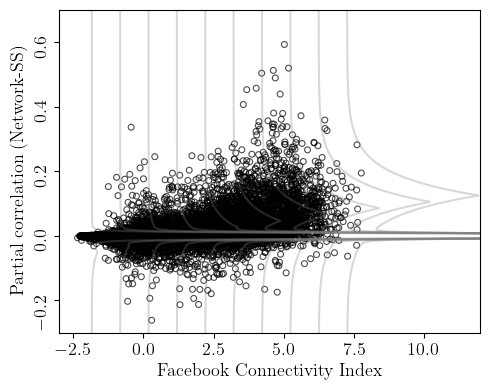

In [32]:
fig, ax = plt.subplots(figsize=(5,4))

# with open(data_save_path + f'NetworkSS_2mcmc_p629_s1500.sav', 'rb') as fr:
#     mcmc2_ss_geo_sci = pickle.load(fr)
    
x_axis = jnp.arange(-1,1,0.001)
rho_tril = mcmc2_ss_geo_sci['rho_lt'].mean(0)

densities_geo_sci_sci = []
for A_ix, (A_k, vals) in enumerate(A_sci_ints_10.items()):
    density = jnp.exp(jnp.array([models.logprior_NetworkSS(scale_spike=vals['scale_spike'],
                                                           scale_slab=vals['scale_slab'],
                                                           w_slab=vals['w_slab'],
                                                           mean_slab=vals['mean_slab'],
                                                           rho_lt=x) for x in x_axis]))
    densities_geo_sci_sci.append(density)
    ax.plot(density+A_sci_mids_10[A_ix], x_axis, alpha=0.3, c='gray')
    
ax.scatter(A_tril_sci, -rho_tril, s=18, linewidth=0.8, alpha=0.7, color='black', facecolors='none', label='partial correlations')
#ax.set_xlim(-3,14)
ax.set_xlim(-3,12)
#ax.set_ylim(-0.5, 0.7)
ax.set_ylim(-0.3, 0.7)
ax.set_xlabel('Facebook Connectivity Index')
ax.set_ylabel('Partial correlation (Network-SS)')

plt.yticks(rotation = 90) 
plt.tight_layout()
plt.savefig('COVID_SS_partial_corrs_SCI.pdf')

plt.show()

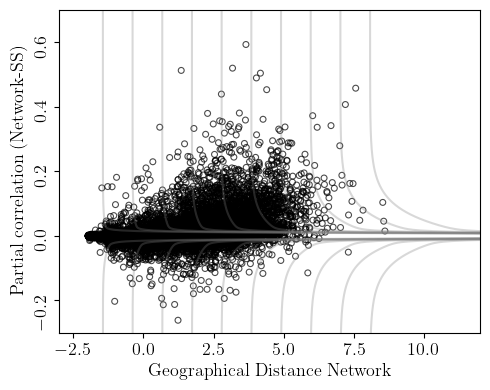

In [38]:
fig, ax = plt.subplots(figsize=(5,4))

# with open(data_save_path +f'NetworkSS_geo_sci_2mcmc.sav', 'rb') as fr:
#     mcmc2_ss_geo_sci = pickle.load(fr)
    
x_axis = jnp.arange(-1,1,0.001)
rho_tril = mcmc2_ss_geo_sci['rho_lt'].mean(0)

densities_geo_sci_geo = []
for A_ix, (A_k, vals) in enumerate(A_geo_ints_10.items()):
    density = jnp.exp(jnp.array([models.logprior_NetworkSS(scale_spike=vals['scale_spike'],
                                                           scale_slab=vals['scale_slab'],
                                                           w_slab=vals['w_slab'],
                                                           mean_slab=vals['mean_slab'],
                                                           rho_lt=x) for x in x_axis]))
    densities_geo_sci_geo.append(density)
    ax.plot(density+A_geo_mids_10[A_ix], x_axis, alpha=0.3, c='gray')
    
ax.scatter(A_tril_geo, -rho_tril, s=18, linewidth=0.8, alpha=0.7, color='black', facecolors='none', label='partial correlations')
#ax.set_xlim(-3,14)
ax.set_xlim(-3,12)
#ax.set_ylim(-0.5, 0.7)
ax.set_ylim(-0.3, 0.7)
ax.set_xlabel('Geographical Distance Network')
ax.set_ylabel('Partial correlation (Network-SS)')

plt.yticks(rotation = 90)
plt.tight_layout()
plt.savefig('COVID_SS_partial_corrs_GEO.pdf')

plt.show()

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import display
from IPython.display import display_html 
import sys
import os
import jax
import numpyro
numpyro.set_platform('cpu')
print(jax.lib.xla_bridge.get_backend().platform)
import jax.numpy as jnp

# paths
_ROOT_DIR = "/home/user/graphical-models-external-networks/"
os.chdir(_ROOT_DIR)
sys.path.append("/home/user/graphical-models-external-networks/Network_Spike_and_Slab/numpyro/functions")

data_path = './Data/COVID/Pre-processed Data/'
data_save_path = '/home/user/mounted_folder/NetworkSS_results/'
if not os.path.exists(data_save_path):
    os.makedirs(data_save_path, mode=0o777)

# load models and functions
import models
import my_utils

covid_vals = jnp.array(pd.read_csv(data_path + 'COVID_629_meta.csv', index_col='Unnamed: 0').values)
geo_clean = jnp.array(jnp.load(data_path + 'GEO_clean_629.npy'))
sci_clean = jnp.array(jnp.load(data_path + 'SCI_clean_629.npy'))
net_no = 2
scale_spike_fixed =0.003

n,p = covid_vals.shape

# Compile results

# 1MCMC
output_dict_ss_geo_sci = {"eta0_0":[],"eta0_coefs":[], "eta1_0":[],"eta1_coefs":[], "eta2_0":[],"eta2_coefs":[],
                    "w_slab":[], "mean_slab":[], "scale_slab":[],"Pos":[], "Neg":[], "Pos_95":[], "Neg_95":[],}


outputs = {"NetworkSS_geo_sci":output_dict_ss_geo_sci }
        
# with open(data_save_path + f'NetworkSS_geo_sci_1mcmc.sav', 'rb') as fr:
#     res_ss_geo_sci = pickle.load(fr)

with open(data_save_path + f'NetworkSS_1mcmc_p629_s1500.sav', 'rb') as fr:
    res_ss_geo_sci = pickle.load(fr)

all_res = {"NetworkSS_geo_sci":res_ss_geo_sci}

for i, res in all_res.items():
    print(i)
    n_samples = res["eta1_0"].shape[0]


    outputs[i]["eta1_0"].append(res["eta1_0"].mean(0))

    try:
        outputs[i]["eta0_0"].append(res["eta0_0"].mean(0))
        outputs[i]["eta2_0"].append(res["eta2_0"].mean(0))
        outputs[i]["w_slab"].append(res["w_slab"].mean(0))
        outputs[i]["mean_slab"].append(res["mean_slab"].mean(0))
        outputs[i]["scale_slab"].append(res["scale_slab"].mean(0))

    except:
        pass

    try:
        outputs[i]["eta1_coefs"].append(res["eta1_coefs"].mean(0))
    except:
        pass

    try:   
        outputs[i]["eta0_coefs"].append(res["eta0_coefs"].mean(0))
        outputs[i]["eta2_coefs"].append(res["eta2_coefs"].mean(0))
    except:
        pass

    prob_slab_all = []
    for cs in range(n_samples):
        prob_slab = my_utils.get_prob_slab(rho_lt=res['rho_lt'][cs], 
                                        mean_slab=res['mean_slab'][cs], 
                                        scale_slab=res['scale_slab'][cs], 
                                        scale_spike=scale_spike_fixed, 
                                        w_slab=res['w_slab'][cs], 
                                        w_spike=(1-res['w_slab'])[cs])
        prob_slab_all.append(prob_slab)
    prob_slab_est = (jnp.array(prob_slab_all)).mean(0)    
    nonzero_preds_5 = (prob_slab_est>0.5).astype(int)
    nonzero_preds_95 = (prob_slab_est>0.95).astype(int)

    Pos_5 = jnp.where(nonzero_preds_5 == True)[0].shape[0]
    Neg_5 = jnp.where(nonzero_preds_5 == False)[0].shape[0]
  
    Pos_95 = jnp.where(nonzero_preds_95 == True)[0].shape[0]
    Neg_95 = jnp.where(nonzero_preds_95 == False)[0].shape[0]

    outputs[i]['Pos'].append(Pos_5)
    outputs[i]['Neg'].append(Neg_5)
    outputs[i]['Pos_95'].append(Pos_95)
    outputs[i]['Neg_95'].append(Neg_95)

outputs_1MCMC = outputs

# 2MCMC

output_dict_ss_geo_sci = {"eta0_0":[],"eta0_coefs":[], "eta1_0":[],"eta1_coefs":[], "eta2_0":[],"eta2_coefs":[],
                    "w_slab":[], "mean_slab":[], "scale_slab":[],"Pos":[], "Neg":[], "Pos_95":[], "Neg_95":[],}


outputs = {"NetworkSS_geo_sci":output_dict_ss_geo_sci}

with open(data_save_path + f'NetworkSS_2mcmc_p629_s1500.sav', 'rb') as fr:
    mcmc2_ss_geo_sci = pickle.load(fr)


all_res_2MCMC = {"NetworkSS_geo_sci":mcmc2_ss_geo_sci}
for i, res in all_res_2MCMC.items():
    print(i)

    n_samples = res["rho_lt"].shape[0]

    prob_slab_all = []
    for cs in range(n_samples):
        prob_slab = my_utils.get_prob_slab(rho_lt=res['rho_lt'][cs], 
                                        mean_slab=res['mean_slab'][cs], 
                                        scale_slab=res['scale_slab'][cs], 
                                        scale_spike=scale_spike_fixed, 
                                        w_slab=res['w_slab'][cs], 
                                        w_spike=(1-res['w_slab'])[cs])
        prob_slab_all.append(prob_slab)
    prob_slab_est = (jnp.array(prob_slab_all)).mean(0)    
    nonzero_preds_5 = (prob_slab_est>0.5).astype(int)
    nonzero_preds_95 = (prob_slab_est>0.95).astype(int)

    Pos_5 = jnp.where(nonzero_preds_5 == True)[0].shape[0]
    Neg_5 = jnp.where(nonzero_preds_5 == False)[0].shape[0]
  
    Pos_95 = jnp.where(nonzero_preds_95 == True)[0].shape[0]
    Neg_95 = jnp.where(nonzero_preds_95 == False)[0].shape[0]

    outputs[i]['Pos'].append(Pos_5)
    outputs[i]['Neg'].append(Neg_5)
    outputs[i]['Pos_95'].append(Pos_95)
    outputs[i]['Neg_95'].append(Neg_95)


outputs_2MCMC = outputs

# Summary

cols = ['Pos', 'Neg', 'Pos_95', 'Neg_95']

res_dict_1MCMC = {"NetworkSS_geo_sci":[]}
for k, output in outputs_1MCMC.items():
    for col in cols:
        try:
            res_dict_1MCMC[k].append(round(jnp.array(output[col]).mean(0),3))
        except:
            res_dict_1MCMC[k].append(np.nan)

cols = ['Pos', 'Neg', 'Pos_95', 'Neg_95']

res_dict_2MCMC = {"NetworkSS_geo_sci":[]}
for k, output in outputs_2MCMC.items():
    for col in cols:
        try:
            res_dict_2MCMC[k].append(round(jnp.array(output[col]).mean(0),3))
        except:
            res_dict_2MCMC[k].append(np.nan)

print('Results for 1MCMC')
pd.DataFrame.from_dict(res_dict_1MCMC, orient='index', 
                       columns=cols).loc[['NetworkSS_geo_sci']]

print('Results for 2MCMC')
df = pd.DataFrame.from_dict(res_dict_2MCMC, orient='index', 
                       columns=cols).loc[['NetworkSS_geo_sci']]

df.index = ['GOLAZO_SS_geo_sci_2mcmc']
df

# NetworkSS_geo_sci 
cols = ["eta0_0", "eta1_0","eta2_0"]
cols_2 = [ "eta0_coefs", "eta1_coefs", "eta2_coefs"]
names = ['E', 'P']
etas_NetworkSS = {}
for k in cols:
    etas_NetworkSS[k] = all_res_2MCMC['NetworkSS_geo_sci']['fixed_params_dict'][k]
    
for k in cols:
    etas_NetworkSS[k] = {'MAP': all_res_2MCMC['NetworkSS_geo_sci']['fixed_params_dict'][k],
               'mean': all_res['NetworkSS_geo_sci'][k].mean(0),
              'ESS': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_geo_sci'][k],0))['Param:0']['n_eff'],
               'r_hat': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_geo_sci'][k],0))['Param:0']['r_hat'],
                }

for k in cols_2:
    for net_ix in range(net_no):
        etas_NetworkSS[f'{k}_{names[net_ix]}'] = {'MAP': all_res_2MCMC['NetworkSS_geo_sci']['fixed_params_dict'][k][net_ix],
                   'mean': all_res['NetworkSS_geo_sci'][k].mean(0)[net_ix],
                  'ESS': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_geo_sci'][k][:,net_ix].flatten(),0))['Param:0']['n_eff'],
                   'r_hat': numpyro.diagnostics.summary(jnp.expand_dims(all_res['NetworkSS_geo_sci'][k][:,net_ix].flatten(),0))['Param:0']['r_hat'],
                    }
        
df_NetworkSS_etas_spec = pd.DataFrame.from_dict(etas_NetworkSS, orient='index')


df_NetworkSS_etas_spec

tril_idx = jnp.tril_indices(n=p, k=-1, m=p)
A_tril_geo = geo_clean[tril_idx]
A_tril_sci = sci_clean[tril_idx]

# NetworkSS

nbins=10

fixed_params_MAP_dict = all_res_2MCMC['NetworkSS_geo_sci']['fixed_params_dict']

negative_fixed_params_MAP_dict = {k:(-v if 'eta0' in k else v) 
                              for k,v in fixed_params_MAP_dict.items()
                             }

etas_dict = negative_fixed_params_MAP_dict

A_geo_ints_10, A_geo_mids_10  = my_utils.get_density_els_marginal(A_tril=A_tril_geo, 
                                                                  A_tril_pos=0, 
                                                                len_A_list=2, nbins=nbins, 
                         eta_dict=etas_dict)

A_sci_ints_10, A_sci_mids_10 = my_utils.get_density_els_marginal(A_tril=A_tril_sci, 
                                                                 A_tril_pos=1, 
                                                                len_A_list=2, nbins=nbins, 
                         eta_dict=etas_dict)

## Final plots

def get_credible_interval(post_chain):
    # Credible Intervals
    sorted_arr = np.sort(post_chain) # for each K sort chain
    len_sample = post_chain.shape[0] # len chain

    # 2.5% percentile: if integer pick value, else average of values at pos5 and pos5+1, recall python idx at 0 (lower bound)
    pos025 = 0.025*len_sample
    if pos025 == np.int(pos025):
        lb025 = sorted_arr[max(np.int(pos025)-1,0)]
    else:
        lb025 = (sorted_arr[max(np.int(pos025)-1,0)] + sorted_arr[np.int(pos025)])/2

    # 97.5% percentile: if integer pick value, else average of values at pos95 and pos95+1, recall python idx at 0 (upper bound)
    pos975 = 0.975*len_sample
    if pos975 == np.int(pos975):
        ub975 = sorted_arr[np.int(pos975)-1]
    else:
        ub975 = (sorted_arr[(np.int(pos975)-1)] + sorted_arr[np.int(pos975)])/2
        
    return (jnp.round(lb025,3), jnp.round(ub975,3))


df_MAP_dict = {'intercept':{'eta0_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta0_0'],3),
                        'eta0_CI':get_credible_interval(res_ss_geo_sci['eta0_0']),
                        'eta1_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta1_0'],3),
                        'eta1_CI':get_credible_interval(res_ss_geo_sci['eta1_0']),
                        'eta2_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta2_0'],3),
                        'eta2_CI':get_credible_interval(res_ss_geo_sci['eta2_0']),},
               
'geo':{'eta0_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta0_coefs_E'],3),
                        'eta0_CI':get_credible_interval(res_ss_geo_sci['eta0_coefs'][:,0]),
                        'eta1_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta1_coefs_E'],3),
                        'eta1_CI':get_credible_interval(res_ss_geo_sci['eta1_coefs'][:,0]),
                        'eta2_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta2_coefs_E'],3),
                        'eta2_CI':get_credible_interval(res_ss_geo_sci['eta2_coefs'][:,0]),},

'sci':{'eta0_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta0_coefs_P'],3),
                        'eta0_CI':get_credible_interval(res_ss_geo_sci['eta0_coefs'][:,1]),
                        'eta1_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta1_coefs_P'],3),
                        'eta1_CI':get_credible_interval(res_ss_geo_sci['eta1_coefs'][:,1]),
                        'eta2_m':jnp.round(df_NetworkSS_etas_spec['MAP']['eta2_coefs_P'],3),
                        'eta2_CI':get_credible_interval(res_ss_geo_sci['eta2_coefs'][:,1]),},
}

pd.DataFrame.from_dict(df_MAP_dict)

pd.DataFrame.from_dict(df_MAP_dict).to_latex()

def MODIFIED_get_density_els_marginal(A_tril, A_min, A_max, A_tril_pos, len_A_list, nbins, eta_dict):
    bins = np.histogram(A_tril, bins=nbins)[1]
    delta = jnp.diff(np.histogram(A_tril, bins=nbins)[1])[0]
    if min(bins) > A_min:
        low = bins[0]
        while low>A_min:
            low -= delta
            bins = jnp.concatenate([jnp.array([low]), bins])
    if max(bins) < A_max:
        high = bins[-1]
        while high<A_max:
            high += delta
            bins = jnp.concatenate([bins, jnp.array([high])])

    A_ints = {}
    A_mids = []
    down = -jnp.inf
    for i in range(-1, len(bins)-2):
        up = bins[i+2]
        if i==-1:
            A_mid = up-(bins[i+3]-bins[i+2])/2
            A_mids.append(A_mid)
        else:
            A_mid = (down+up)/2
            A_mids.append(A_mid)
        A_int_ix = jnp.where((A_tril>down)&(A_tril<=up))[0]

        A_key = f'{jnp.round(down,2)} to {jnp.round(up,2)}'
        down = bins[i+2]

        zeros = jnp.zeros((len_A_list))
        A_singlevals = zeros.at[A_tril_pos].set(A_mid)

        par_dict = my_utils.from_etas_to_params(coef_dict=eta_dict, p=1, 
        model='golazo_ss', A_list=A_singlevals)

        A_ints[A_key] = par_dict

    A_mids = jnp.array(A_mids)
    return A_ints, A_mids

# run to have plots in LaTeX format

params = {'font.family': 'serif',
          'text.usetex': True,
          'axes.titlesize': 13,
          'axes.labelsize': 13,
          'xtick.labelsize': 13,
          'ytick.labelsize': 13,
          'legend.fontsize': 9,
          'font.weight': 'bold'}
plt.rcParams.update(params)

fig, ax = plt.subplots( figsize=(5,4))

nbins=10
MODIFIED_A_geo_ints_10, MODIFIED_A_geo_mids_10  = MODIFIED_get_density_els_marginal(A_tril=A_tril_geo, 
                                                                  A_min=-2, A_max=6.5, 
                                                                  A_tril_pos=0, 
                                                                len_A_list=2, nbins=nbins,  eta_dict=etas_dict)

MODIFIED_A_sci_ints_10, MODIFIED_A_sci_mids_10 = MODIFIED_get_density_els_marginal(A_tril=A_tril_sci, 
                                                                                   A_min=-2, A_max=6.5,
                                                                 A_tril_pos=1, 
                                                                len_A_list=2, nbins=nbins, eta_dict=etas_dict)


MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_sci_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_sci = MODIFIED_df.round(decimals = 5)

MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_geo_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_geo = MODIFIED_df.round(decimals = 5)

dfs = [MODIFIED_df_geo, MODIFIED_df_sci, ]
df_names = ['geo', 'sci', ]
ticklabs = [MODIFIED_A_geo_mids_10, MODIFIED_A_sci_mids_10 ]
legendlabs = ['Geographical Distance Network', 'Facebook Connectivity Index', ]
colors = ['black', 'gray']


for df_ix, df in enumerate(dfs):
    ax.plot(ticklabs[df_ix], df['w_slab'].values, linewidth=1.2, label=legendlabs[df_ix], color=colors[df_ix])

    ax.set_ylabel('Probability of slab')
    ax.set_xlabel('Network values')

plt.legend()
plt.yticks(rotation = 90)
plt.tight_layout()
plt.savefig('Stock_SS_prob_slab.pdf')

plt.show()

fig, ax = plt.subplots( figsize=(5,4))

nbins=10
MODIFIED_A_geo_ints_10, MODIFIED_A_geo_mids_10  = MODIFIED_get_density_els_marginal(A_tril=A_tril_geo, 
                                                                  A_min=-2, A_max=6.5, 
                                                                  A_tril_pos=0, 
                                                                len_A_list=2, nbins=nbins,  eta_dict=etas_dict)

MODIFIED_A_sci_ints_10, MODIFIED_A_sci_mids_10 = MODIFIED_get_density_els_marginal(A_tril=A_tril_sci, 
                                                                                   A_min=-2, A_max=6.5,
                                                                 A_tril_pos=1, 
                                                                len_A_list=2, nbins=nbins, eta_dict=etas_dict)


MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_sci_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_sci = MODIFIED_df.round(decimals = 5)

MODIFIED_df = pd.DataFrame.from_dict(MODIFIED_A_geo_ints_10, orient='index')
MODIFIED_df = MODIFIED_df.astype('float64')
MODIFIED_df_geo = MODIFIED_df.round(decimals = 5)

dfs = [MODIFIED_df_geo, MODIFIED_df_sci, ]
df_names = ['geo', 'sci', ]
ticklabs = [MODIFIED_A_geo_mids_10, MODIFIED_A_sci_mids_10 ]
legendlabs = ['Geographical Distance Network', 'Facebook Connectivity Index', ]
colors = ['black', 'gray']

for df_ix, df in enumerate(dfs):
    ax.plot(ticklabs[df_ix], df['mean_slab'].values, linewidth=1.2, label=legendlabs[df_ix], color=colors[df_ix])

    ax.set_ylabel('Slab location')
    ax.set_xlabel('Network values')

plt.legend()
plt.yticks(rotation = 90)
plt.tight_layout()
plt.savefig('Stock_SS_mean_slab.pdf')

plt.show()

fig, ax = plt.subplots(figsize=(5,4))

# with open(data_save_path + f'NetworkSS_2mcmc_p629_s1500.sav', 'rb') as fr:
#     mcmc2_ss_geo_sci = pickle.load(fr)
    
x_axis = jnp.arange(-1,1,0.001)
rho_tril = mcmc2_ss_geo_sci['rho_lt'].mean(0)

densities_geo_sci_sci = []
for A_ix, (A_k, vals) in enumerate(A_sci_ints_10.items()):
    density = jnp.exp(jnp.array([models.logprior_NetworkSS(scale_spike=vals['scale_spike'],
                                                           scale_slab=vals['scale_slab'],
                                                           w_slab=vals['w_slab'],
                                                           mean_slab=vals['mean_slab'],
                                                           rho_lt=x) for x in x_axis]))
    densities_geo_sci_sci.append(density)
    ax.plot(density+A_sci_mids_10[A_ix], x_axis, alpha=0.3, c='gray')
    
ax.scatter(A_tril_sci, -rho_tril, s=18, linewidth=0.8, alpha=0.7, color='black', facecolors='none', label='partial correlations')
#ax.set_xlim(-3,14)
ax.set_xlim(-3,12)
#ax.set_ylim(-0.5, 0.7)
ax.set_ylim(-0.3, 0.7)
ax.set_xlabel('Facebook Connectivity Index')
ax.set_ylabel('Partial correlation (Network-SS)')

plt.yticks(rotation = 90) 
plt.tight_layout()
plt.savefig('COVID_SS_partial_corrs_SCI.pdf')

plt.show()

fig, ax = plt.subplots(figsize=(5,4))

# with open(data_save_path +f'NetworkSS_geo_sci_2mcmc.sav', 'rb') as fr:
#     mcmc2_ss_geo_sci = pickle.load(fr)
    
x_axis = jnp.arange(-1,1,0.001)
rho_tril = mcmc2_ss_geo_sci['rho_lt'].mean(0)

densities_geo_sci_geo = []
for A_ix, (A_k, vals) in enumerate(A_geo_ints_10.items()):
    density = jnp.exp(jnp.array([models.logprior_NetworkSS(scale_spike=vals['scale_spike'],
                                                           scale_slab=vals['scale_slab'],
                                                           w_slab=vals['w_slab'],
                                                           mean_slab=vals['mean_slab'],
                                                           rho_lt=x) for x in x_axis]))
    densities_geo_sci_geo.append(density)
    ax.plot(density+A_geo_mids_10[A_ix], x_axis, alpha=0.3, c='gray')
    
ax.scatter(A_tril_geo, -rho_tril, s=18, linewidth=0.8, alpha=0.7, color='black', facecolors='none', label='partial correlations')
#ax.set_xlim(-3,14)
ax.set_xlim(-3,12)
#ax.set_ylim(-0.5, 0.7)
ax.set_ylim(-0.3, 0.7)
ax.set_xlabel('Geographical Distance Network')
ax.set_ylabel('Partial correlation (Network-SS)')

plt.yticks(rotation = 90)
plt.tight_layout()
plt.savefig('COVID_SS_partial_corrs_GEO.pdf')

plt.show()



cpu


/home/user/.virtualenvs/graph-network/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
